In [18]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Layer, Reshape, Multiply, Conv2D, BatchNormalization, Activation, Add, Input, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [2]:
base = '/Users/robp/scm/personal/github.com/robpickerill/thesis'
csv_file = os.path.join(base, 'ham10000_data/HAM10000_metadata.csv')
img_dir = os.path.join(base, 'ham10000_data/images')
file_ext = '.jpg'

df = pd.read_csv(csv_file)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(img_dir, x + file_ext))

print(df.head())
print(f"Total samples in dataset: {len(df)}")

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                          image_path  
0  /Users/robp/scm/personal/github.com/robpickeri...  
1  /Users/robp/scm/personal/github.com/robpickeri...  
2  /Users/robp/scm/personal/github.com/robpickeri...  
3  /Users/robp/scm/personal/github.com/robpickeri...  
4  /Users/robp/scm/personal/github.com/robpickeri...  
Total samples in dataset: 10015


In [3]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    bn_axis = 3
    filters1, filters2, filters3 = filters
    conv_name_base = f'conv{stage}_block{block}_'

    x = Conv2D(filters1, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '1_conv')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '1_bn')(x)
    x = Activation('relu', name=conv_name_base + '1_relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same',
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '2_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '2_bn')(x)
    x = Activation('relu', name=conv_name_base + '2_relu')(x)

    x = Conv2D(filters3, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '3_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '3_bn')(x)

    x = Add(name=conv_name_base + 'add')([x, input_tensor])
    x = Activation('relu', name=conv_name_base + 'out')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    bn_axis = 3
    filters1, filters2, filters3 = filters
    conv_name_base = f'conv{stage}_block{block}_'

    x = Conv2D(filters1, (1, 1), strides=strides,
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '1_conv')(input_tensor)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '1_bn')(x)
    x = Activation('relu', name=conv_name_base + '1_relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '2_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '2_bn')(x)
    x = Activation('relu', name=conv_name_base + '2_relu')(x)

    x = Conv2D(filters3, (1, 1),
               use_bias=True,
               kernel_initializer='he_normal',
               name=conv_name_base + '3_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '3_bn')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      use_bias=True,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '0_conv')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=conv_name_base + '0_bn')(shortcut)

    x = Add(name=conv_name_base + 'add')([x, shortcut])
    x = Activation('relu', name=conv_name_base + 'out')(x)
    return x

def build_resnet50(input_shape, num_classes):
    inputs = Input(shape=input_shape, name='input_1')
    bn_axis = 3  # channels_last

    # Stage 1
    x = ZeroPadding2D(padding=(3, 3), name='conv1_pad')(inputs)
    x = Conv2D(64, (7, 7), strides=(2, 2),
               padding='valid', use_bias=True,
               kernel_initializer='he_normal',
               name='conv1_conv')(x)
    x = BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1_pool')(x)

    # Stage 2
    x = conv_block(x, 3, [64, 64, 256], stage=2, block=1, strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=2)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block=3)

    # Stage 3
    x = conv_block(x, 3, [128, 128, 512], stage=3, block=1)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=2)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=3)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block=4)

    # Stage 4
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block=1)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=2)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=3)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=4)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=5)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=6)

    # Stage 5
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block=1)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=2)
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block=3)

    # Global Pooling & Classifier
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs, outputs, name='resnet50')
    return model

def transfer_weights(base_model, target_model):
    """
    Transfer weights from a Keras ResNet50 base_model into the custom ResNet50
    architecture whenever layer names match.
    """
    for layer in target_model.layers:
        try:
            pretrained_layer = base_model.get_layer(layer.name)
            layer.set_weights(pretrained_layer.get_weights())
        except Exception:
            # If layer doesn't exist in pretrained base, skip
            pass


In [4]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * y_true * tf.math.pow((1 - y_pred), gamma)
        return tf.reduce_mean(tf.reduce_sum(weights * cross_entropy, axis=-1))
    return focal_loss_fixed

In [5]:
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# For tracking the best fold, to later evaluate performance
best_fold = None
best_auc_across_folds = 0.0

# For collecting metrics across folds
fold_accuracies = []
fold_aucs = []
fold_losses = []

# Epochs for each phase
EPOCHS_PHASE1 = 20   # Freeze the backbone
EPOCHS_PHASE2 = 200  # Fine-tuning

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 7

base_resnet50 = ResNet50(weights='imagenet', include_top=False, pooling=None)

# Data augmentation
datagen_train = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen_val = ImageDataGenerator(rescale=1.0/255.0)

# Get unique class labels (strings)
all_class_labels = sorted(df['dx'].unique())

# Compute global class weights for the entire dataset
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array(all_class_labels),
    y=df['dx'].values
)
# Map to dictionary: {class_index: weight}
class_weights_dict = {}
for label, w in zip(all_class_labels, class_weights_array):
    # Index of this label in the alphabetical-sorted list
    idx = all_class_labels.index(label)
    class_weights_dict[idx] = w
print("Class weights dict:", class_weights_dict)

fold_index = 1
for train_idx, val_idx in skf.split(df, df['dx']):
    print(f"\n\n===== FOLD {fold_index}/{k_folds} =====")

    # ------------------------------------------------------
    # 4.1) CREATE DATAFRAMES FOR THIS FOLD
    # ------------------------------------------------------
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = df.iloc[val_idx].reset_index(drop=True)

    print("Train size:", len(train_df), "Val size:", len(val_df))
    print("Train distribution:\n", train_df['dx'].value_counts())
    print("Val distribution:\n", val_df['dx'].value_counts())

    # ------------------------------------------------------
    # 4.2) FLOW FROM DATAFRAME: TRAIN & VAL
    # ------------------------------------------------------
    train_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',
        y_col='dx',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    val_generator = datagen_val.flow_from_dataframe(
        dataframe=val_df,
        x_col='image_path',
        y_col='dx',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Extract class names from the train_generator
    # The generator creates an internal mapping of classes -> indices
    class_names = list(train_generator.class_indices.keys())

    # ------------------------------------------------------
    # 4.3) BUILD & COMPILE MODEL FROM SCRATCH FOR EACH FOLD
    # ------------------------------------------------------
    custom_resnet = build_resnet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES)
    # Transfer weights from base Keras ResNet50 (ImageNet) to custom ResNet
    transfer_weights(base_resnet50, custom_resnet)

    # Freeze layers in the main body
    for layer in custom_resnet.layers:
        if layer.name.startswith('conv'):
            layer.trainable = False
        else:
            layer.trainable = True

    custom_resnet.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss=focal_loss(),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # ------------------------------------------------------
    # 4.4) CALLBACKS & TRAIN (PHASE 1)
    # ------------------------------------------------------
    model_path_phase1 = f"resnet50_fold{fold_index}_phase1.keras"
    callbacks_phase1 = [
        EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True, mode='max', verbose=1),
        ModelCheckpoint(model_path_phase1, monitor='val_auc', save_best_only=True, mode='max', verbose=1)
    ]

    history_phase1 = custom_resnet.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS_PHASE1,
        class_weight=class_weights_dict,
        callbacks=callbacks_phase1
    )

    # Load best weights from Phase 1
    custom_resnet.load_weights(model_path_phase1)

    # ------------------------------------------------------
    # 4.5) UNFREEZE & FINE-TUNING (PHASE 2)
    # ------------------------------------------------------
    for layer in custom_resnet.layers:
        layer.trainable = True

    custom_resnet.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss=focal_loss(),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    model_path_phase2 = f"resnet50_fold{fold_index}_phase2.keras"
    callbacks_phase2 = [
        ReduceLROnPlateau(monitor='val_auc', factor=0.1, patience=3, mode='max', verbose=1),
        EarlyStopping(monitor='val_auc', patience=7, restore_best_weights=True, mode='max', verbose=1),
        ModelCheckpoint(model_path_phase2, monitor='val_auc', save_best_only=True, mode='max', verbose=1)
    ]

    history_phase2 = custom_resnet.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS_PHASE2,
        class_weight=class_weights_dict,
        callbacks=callbacks_phase2
    )

    # Load best weights from Phase 2
    custom_resnet.load_weights(model_path_phase2)

    # ------------------------------------------------------
    # 4.6) EVALUATE ON THIS FOLD
    # ------------------------------------------------------
    loss, accuracy, auc_val = custom_resnet.evaluate(val_generator, verbose=0)
    print(f"FOLD {fold_index} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, AUC: {auc_val:.4f}")

    fold_losses.append(loss)
    fold_accuracies.append(accuracy)
    fold_aucs.append(auc_val)

    # Check if this fold is the best so far
    if auc_val > best_auc_across_folds:
        best_auc_across_folds = auc_val
        best_fold = fold_index

    # Move to next fold
    fold_index += 1

# -------------------------------------------------------------------------
# 5) CROSS-VALIDATION RESULTS
# -------------------------------------------------------------------------
print("\n=== CROSS-VALIDATION RESULTS ===")
print(f"Average Loss over {k_folds} folds  : {np.mean(fold_losses):.4f} (± {np.std(fold_losses):.4f})")
print(f"Average Accuracy over {k_folds} folds: {np.mean(fold_accuracies):.4f} (± {np.std(fold_accuracies):.4f})")
print(f"Average AUC over {k_folds} folds     : {np.mean(fold_aucs):.4f} (± {np.std(fold_aucs):.4f})")

Class weights dict: {0: 4.375273044997815, 1: 2.78349082823791, 2: 1.301832835044846, 3: 12.440993788819876, 4: 1.2854575792581184, 5: 0.21338020666879728, 6: 10.075452716297788}


===== FOLD 1/5 =====
Train size: 8012 Val size: 2003
Train distribution:
 dx
nv       5364
mel       890
bkl       879
bcc       411
akiec     262
vasc      114
df         92
Name: count, dtype: int64
Val distribution:
 dx
nv       1341
mel       223
bkl       220
bcc       103
akiec      65
vasc       28
df         23
Name: count, dtype: int64
Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


/Users/robp/scm/personal/github.com/robpickerill/thesis/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5886 - auc: 0.8390 - loss: 0.2401
Epoch 1: val_auc improved from -inf to 0.88387, saving model to resnet50_fold1_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 75s 289ms/step - accuracy: 0.5888 - auc: 0.8391 - loss: 0.2400 - val_accuracy: 0.6695 - val_auc: 0.8839 - val_loss: 0.1719
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6691 - auc: 0.8675 - loss: 0.1972
Epoch 2: val_auc improved from 0.88387 to 0.88900, saving model to resnet50_fold1_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.6691 - auc: 0.8675 - loss: 0.1972 - val_accuracy: 0.6695 - val_auc: 0.8890 - val_loss: 0.1758
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6751 - auc: 0.8720 - loss: 0.1971
Epoch 3: val_auc improved from 0.88900 to 0.89107, saving model to resnet50_fold1_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 270ms/step - accuracy: 0.6751 - auc: 0.8720 - loss: 0.1971 - val_accuracy: 

/Users/robp/scm/personal/github.com/robpickerill/thesis/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5741 - auc: 0.8323 - loss: 0.2514
Epoch 1: val_auc improved from -inf to 0.88130, saving model to resnet50_fold2_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 307ms/step - accuracy: 0.5744 - auc: 0.8324 - loss: 0.2513 - val_accuracy: 0.6695 - val_auc: 0.8813 - val_loss: 0.1727
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6664 - auc: 0.8707 - loss: 0.1895
Epoch 2: val_auc improved from 0.88130 to 0.88819, saving model to resnet50_fold2_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 70s 276ms/step - accuracy: 0.6664 - auc: 0.8707 - loss: 0.1895 - val_accuracy: 0.6695 - val_auc: 0.8882 - val_loss: 0.1719
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.6768 - auc: 0.8819 - loss: 0.1732
Epoch 3: val_auc improved from 0.88819 to 0.89851, saving model to resnet50_fold2_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 267ms/step - accuracy: 0.6768 - auc: 0.8819 - loss: 0.1733 - val_accuracy: 

/Users/robp/scm/personal/github.com/robpickerill/thesis/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5976 - auc: 0.8447 - loss: 0.2271
Epoch 1: val_auc improved from -inf to 0.87082, saving model to resnet50_fold3_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 281ms/step - accuracy: 0.5977 - auc: 0.8447 - loss: 0.2270 - val_accuracy: 0.6695 - val_auc: 0.8708 - val_loss: 0.1781
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6681 - auc: 0.8709 - loss: 0.1931
Epoch 2: val_auc improved from 0.87082 to 0.88565, saving model to resnet50_fold3_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 268ms/step - accuracy: 0.6681 - auc: 0.8709 - loss: 0.1930 - val_accuracy: 0.6695 - val_auc: 0.8857 - val_loss: 0.1720
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6597 - auc: 0.8698 - loss: 0.1991
Epoch 3: val_auc did not improve from 0.88565
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.6598 - auc: 0.8698 - loss: 0.1990 - val_accuracy: 0.6695 - val_auc: 0.8831 - val_loss: 0.1756
Epoch

/Users/robp/scm/personal/github.com/robpickerill/thesis/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.5656 - auc: 0.8312 - loss: 0.2444
Epoch 1: val_auc improved from -inf to 0.88335, saving model to resnet50_fold4_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 288ms/step - accuracy: 0.5659 - auc: 0.8313 - loss: 0.2443 - val_accuracy: 0.6695 - val_auc: 0.8834 - val_loss: 0.1718
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.6756 - auc: 0.8733 - loss: 0.1835
Epoch 2: val_auc improved from 0.88335 to 0.88474, saving model to resnet50_fold4_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 271ms/step - accuracy: 0.6756 - auc: 0.8733 - loss: 0.1836 - val_accuracy: 0.6695 - val_auc: 0.8847 - val_loss: 0.1730
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.6674 - auc: 0.8751 - loss: 0.1864
Epoch 3: val_auc improved from 0.88474 to 0.88922, saving model to resnet50_fold4_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 67s 268ms/step - accuracy: 0.6674 - auc: 0.8751 - loss: 0.1864 - val_accuracy: 

/Users/robp/scm/personal/github.com/robpickerill/thesis/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5518 - auc: 0.8251 - loss: 0.2498
Epoch 1: val_auc improved from -inf to 0.87943, saving model to resnet50_fold5_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 88s 295ms/step - accuracy: 0.5521 - auc: 0.8252 - loss: 0.2497 - val_accuracy: 0.6695 - val_auc: 0.8794 - val_loss: 0.1771
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6648 - auc: 0.8681 - loss: 0.1962
Epoch 2: val_auc improved from 0.87943 to 0.88904, saving model to resnet50_fold5_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 272ms/step - accuracy: 0.6648 - auc: 0.8681 - loss: 0.1962 - val_accuracy: 0.6695 - val_auc: 0.8890 - val_loss: 0.1714
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6783 - auc: 0.8767 - loss: 0.1852
Epoch 3: val_auc improved from 0.88904 to 0.89048, saving model to resnet50_fold5_phase1.keras
251/251 ━━━━━━━━━━━━━━━━━━━━ 68s 269ms/step - accuracy: 0.6783 - auc: 0.8767 - loss: 0.1852 - val_accuracy: 

In [19]:
best_model_path = f"resnet50_fold{best_fold}_phase2.keras"

# -------------------------------------------------------------------------
# 6) EVALUATE BEST MODEL ON TEST SET
# -------------------------------------------------------------------------

# Load best model
best_model = tf.keras.models.load_model(best_model_path, compile=False)


In [20]:
# Classification report

# Get predictions
y_pred = np.argmax(best_model.predict(test_generator), axis=-1)
y_true = test_generator.classes

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))




63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 278ms/step

=== CLASSIFICATION REPORT ===
Classification Report:
               precision    recall  f1-score   support

       akiec       0.90      0.67      0.77        66
         bcc       0.92      0.85      0.88       103
         bkl       0.76      0.92      0.83       219
          df       0.95      0.91      0.93        23
         mel       0.85      0.91      0.87       223
          nv       0.99      0.96      0.97      1341
        vasc       1.00      1.00      1.00        28

    accuracy                           0.93      2003
   macro avg       0.91      0.89      0.89      2003
weighted avg       0.94      0.93      0.94      2003



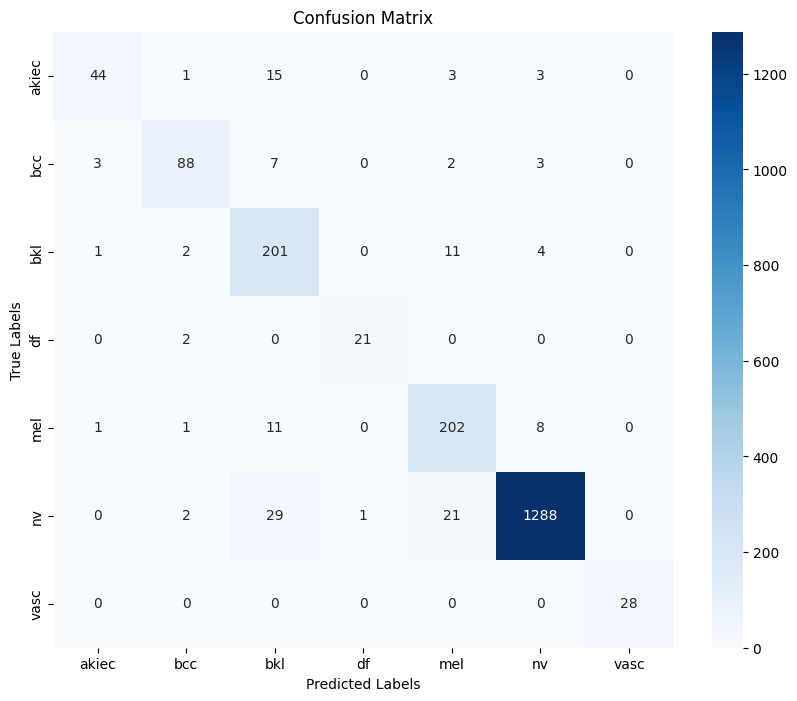

In [21]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()